In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.preprocessing import normalize

# Hàm mục tiêu để đánh giá hiệu suất HMM
def evaluate_hmm(transition_matrix, observations, n_states, start_prob, emission_prob):
    model = hmm.CategoricalHMM(n_components=n_states)
    model.startprob_ = start_prob
    model.transmat_ = transition_matrix
    model.emissionprob_ = emission_prob
    score = model.score(observations)
    return score, model

# Hàm PSO để tối ưu hóa ma trận chuyển trạng thái
def pso_optimize_hmm(observations, n_states, start_prob, emission_prob, n_particles=30, max_iter=100):
    w = 0.5  # Trọng số quán tính
    c1 = 1.5  # Hệ số học cá nhân
    c2 = 1.5  # Hệ số học xã hội

    particles = []
    velocities = []
    pbest = []
    pbest_scores = []
    gbest = None
    gbest_score = -np.inf
    history = {'gbest_scores': [], 'particle_scores': []}

    # Khởi tạo đàn hạt
    for _ in range(n_particles):
        trans_mat = np.random.rand(n_states, n_states)
        trans_mat = normalize(trans_mat, norm='l1', axis=1)
        particles.append(trans_mat)
        velocities.append(np.zeros((n_states, n_states)))
        score, _ = evaluate_hmm(trans_mat, observations, n_states, start_prob, emission_prob)
        pbest.append(trans_mat)
        pbest_scores.append(score)
        if score > gbest_score:
            gbest_score = score
            gbest = trans_mat.copy()

    # Vòng lặp PSO
    for iter in range(max_iter):
        particle_scores = []
        for i in range(n_particles):
            r1, r2 = np.random.rand(), np.random.rand()
            velocities[i] = (w * velocities[i] +
                             c1 * r1 * (pbest[i] - particles[i]) +
                             c2 * r2 * (gbest - particles[i]))
            particles[i] += velocities[i]
            particles[i] = normalize(np.abs(particles[i]), norm='l1', axis=1)
            score, _ = evaluate_hmm(particles[i], observations, n_states, start_prob, emission_prob)
            particle_scores.append(score)
            if score > pbest_scores[i]:
                pbest_scores[i] = score
                pbest[i] = particles[i].copy()
            if score > gbest_score:
                gbest_score = score
                gbest = particles[i].copy()
        history['gbest_scores'].append(gbest_score)
        history['particle_scores'].append(particle_scores)

    _, model = evaluate_hmm(gbest, observations, n_states, start_prob, emission_prob)
    return gbest, gbest_score, history, model

In [2]:
def plot_results(true_transmat, optimal_transmat, history, observations, model, n_states, states, observations_labels):
    # 1. Biểu đồ hội tụ của PSO
    plt.figure(figsize=(10, 5))
    plt.plot(history['gbest_scores'], label='Best Log-Likelihood')
    plt.xlabel('Iteration')
    plt.ylabel('Log-Likelihood')
    plt.title('PSO Convergence')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Biểu đồ so sánh ma trận chuyển trạng thái
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.imshow(true_transmat, cmap='viridis', vmin=0, vmax=1)
    ax1.set_title('True Transition Matrix')
    ax1.set_xlabel('To State')
    ax1.set_ylabel('From State')
    ax1.set_xticks(np.arange(n_states))
    ax1.set_yticks(np.arange(n_states))
    ax1.set_xticklabels(states)
    ax1.set_yticklabels(states)
    ax2.imshow(optimal_transmat, cmap='viridis', vmin=0, vmax=1)
    ax2.set_title('Optimized Transition Matrix')
    ax2.set_xlabel('To State')
    ax2.set_ylabel('From State')
    ax2.set_xticks(np.arange(n_states))
    ax2.set_yticks(np.arange(n_states))
    ax2.set_xticklabels(states)
    ax2.set_yticklabels(states)
    plt.colorbar(ax2.imshow(optimal_transmat, cmap='viridis', vmin=0, vmax=1), ax=ax2)
    plt.tight_layout()
    plt.show()

    # 3. Biểu đồ phân tán điểm số của các hạt
    plt.figure(figsize=(10, 5))
    for iter in range(0, len(history['particle_scores']), len(history['particle_scores'])//5):
        scores = history['particle_scores'][iter]
        plt.scatter([iter]*len(scores), scores, alpha=0.5, label=f'Iter {iter}' if iter == 0 else None)
    plt.plot(history['gbest_scores'], color='red', label='Best Score', linewidth=2)
    plt.xlabel('Iteration')
    plt.ylabel('Log-Likelihood')
    plt.title('Particle Scores Over Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4. Biểu đồ chuỗi quan sát và trạng thái dự đoán
    states_pred = model.predict(observations)
    plt.figure(figsize=(12, 5))
    time = np.arange(len(observations))
    plt.plot(time, observations.flatten(), 'o-', label='Observations', alpha=0.7)
    plt.scatter(time, states_pred, c=states_pred, cmap='viridis', label='Predicted States', s=100)
    plt.xlabel('Time')
    plt.ylabel('Observation/State')
    plt.yticks([0, 1], observations_labels)
    plt.title('Observations and Predicted States')
    plt.legend()
    plt.grid(True)
    plt.show()

Ma trận chuyển trạng thái tối ưu:
[[1.65773232e-01 8.34226768e-01]
 [9.99999998e-01 2.36486718e-09]]
Điểm số log-likelihood: -2.7618414941707043
Ma trận chuyển trạng thái tối ưu:
[[1.66307756e-01 8.33692244e-01]
 [1.00000000e+00 8.02885027e-13]]
Điểm số log-likelihood: -2.761840549482171

Dự đoán trạng thái ẩn cho chuỗi quan sát [Dry, Wet, Dry, Wet, Dry, Dry]:
Thời điểm 0: Quan sát = Dry, Trạng thái ẩn = Sunny
Thời điểm 1: Quan sát = Wet, Trạng thái ẩn = Rainy
Thời điểm 2: Quan sát = Dry, Trạng thái ẩn = Sunny
Thời điểm 3: Quan sát = Wet, Trạng thái ẩn = Rainy
Thời điểm 4: Quan sát = Dry, Trạng thái ẩn = Sunny
Thời điểm 5: Quan sát = Dry, Trạng thái ẩn = Rainy


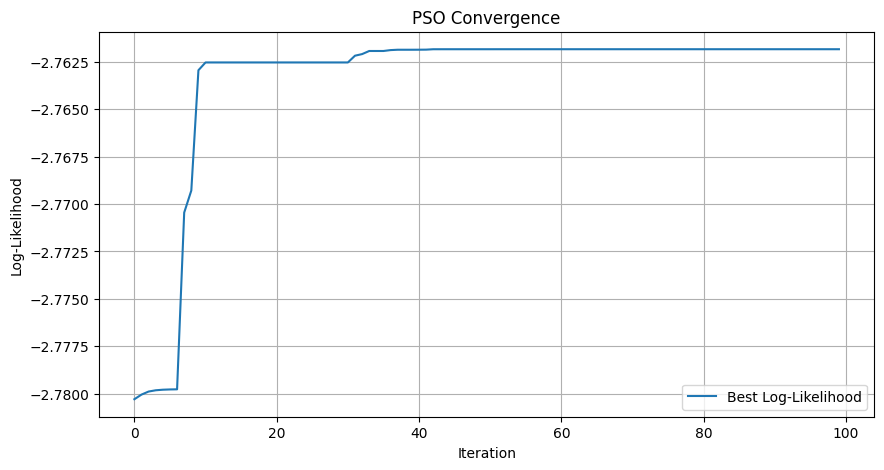

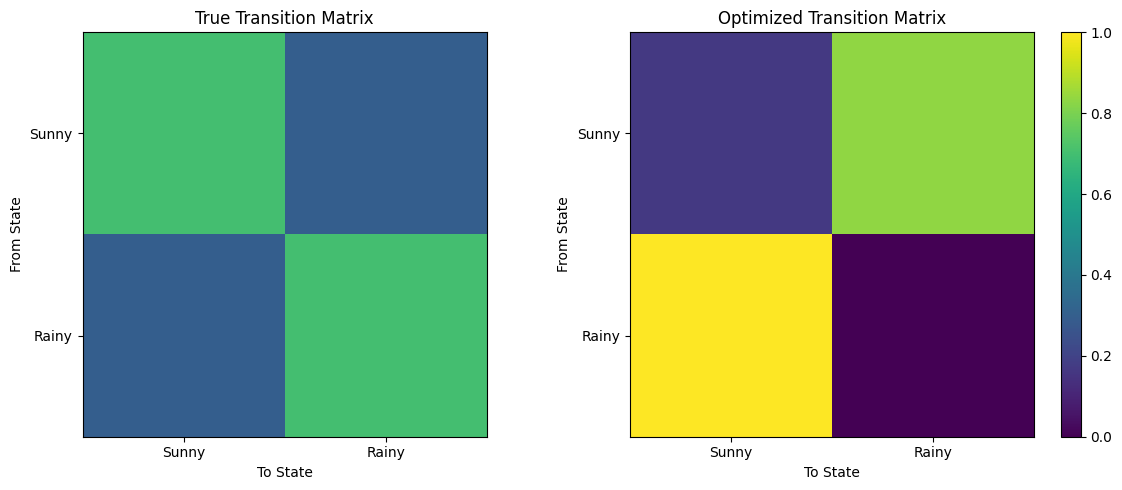

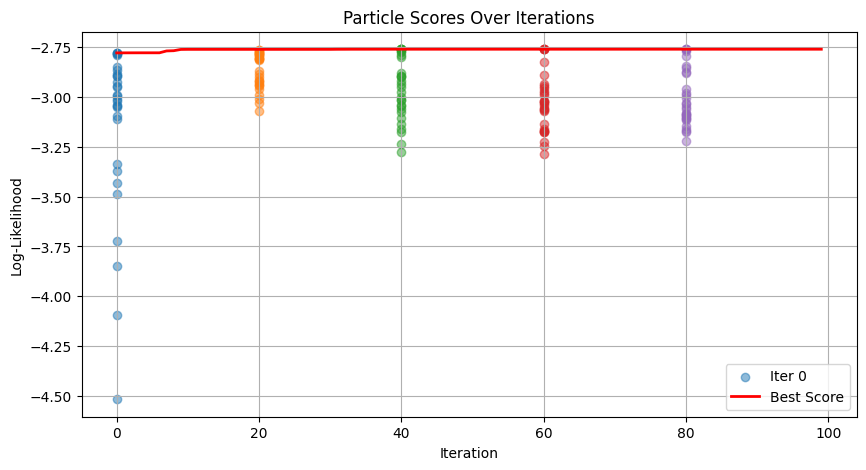

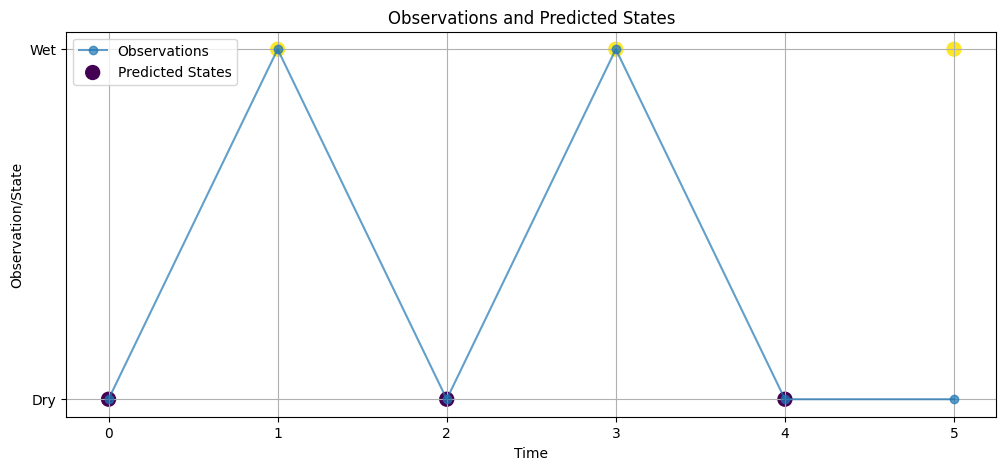

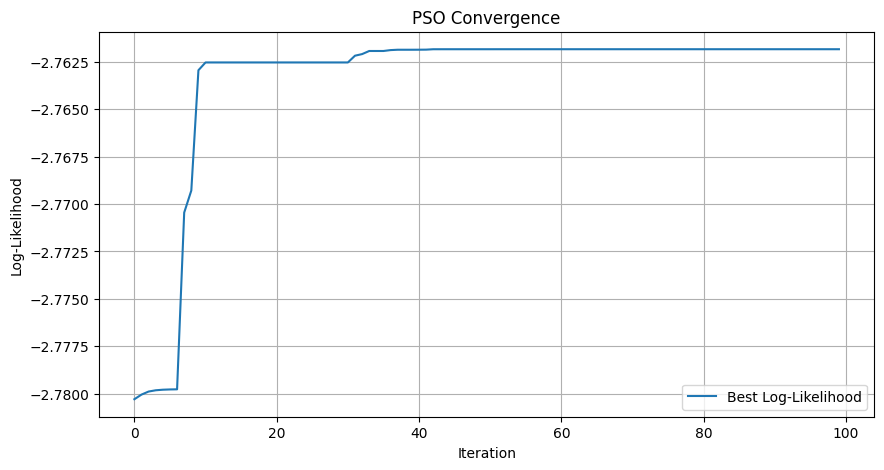

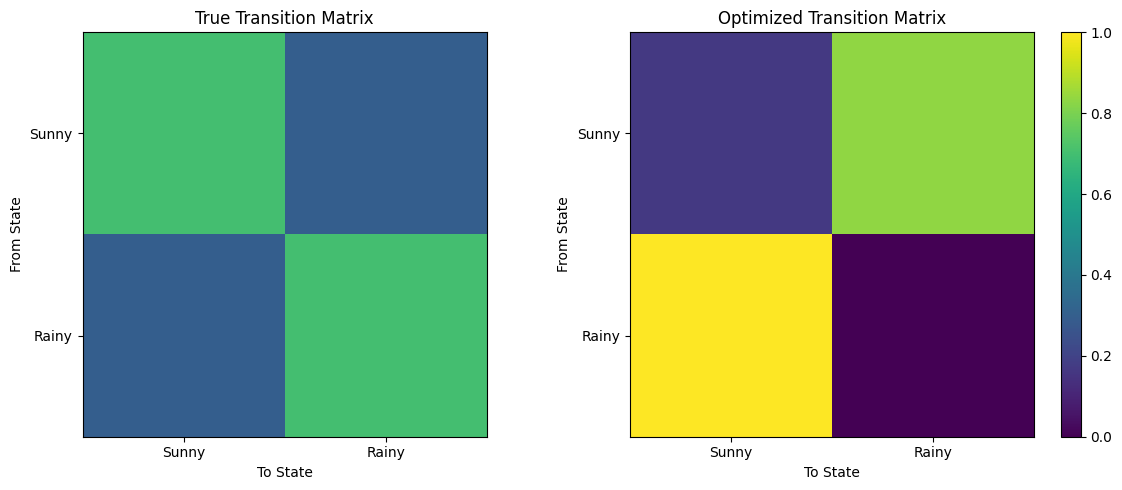

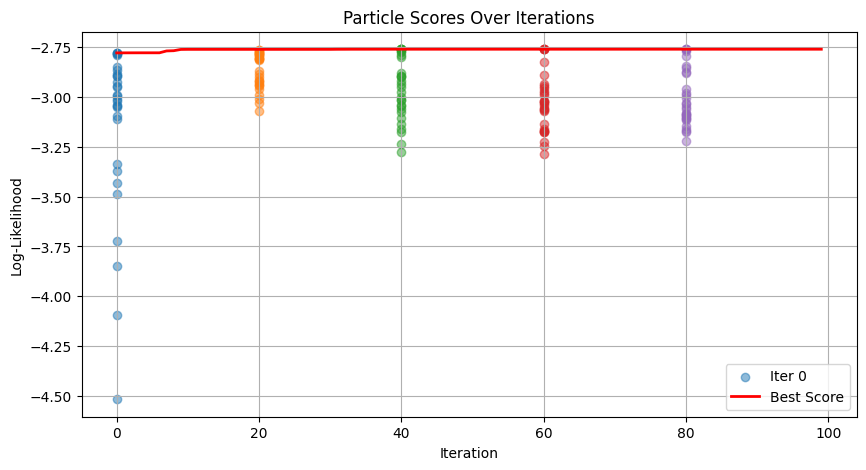

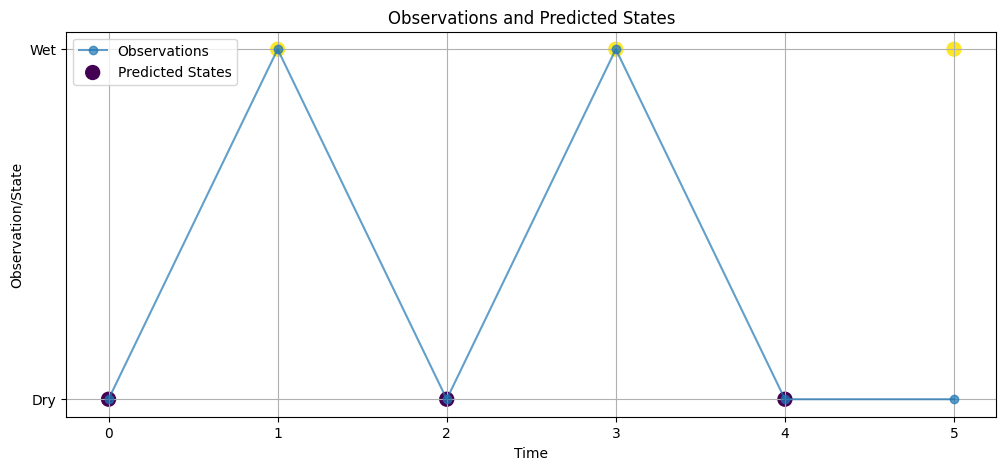

In [3]:
states = ["Sunny", "Rainy"]
observations_labels = ["Dry", "Wet"]
n_states = 2
start_prob = np.array([0.6, 0.4])
true_transmat = np.array([[0.7, 0.3],
                          [0.3, 0.7]])
emission_prob = np.array([[0.9, 0.1],
                          [0.2, 0.8]])
observations_sequence = np.array([0, 1, 0, 1, 0, 0]).reshape(-1, 1)

# Chạy PSO để tối ưu hóa
optimal_transmat, optimal_score, history, optimized_model = pso_optimize_hmm(
    observations_sequence, n_states, start_prob, emission_prob)

# In kết quả
print("Ma trận chuyển trạng thái tối ưu:")
print(optimal_transmat)
print("Điểm số log-likelihood:", optimal_score)

# Vẽ các biểu đồastates = ["Sunny", "Rainy"]
observations_labels = ["Dry", "Wet"]
n_states = 2
start_prob = np.array([0.6, 0.4])
true_transmat = np.array([[0.7, 0.3],
                          [0.3, 0.7]])
emission_prob = np.array([[0.9, 0.1],
                          [0.2, 0.8]])
observations_sequence = np.array([0, 1, 0, 1, 0, 0]).reshape(-1, 1)

# Chạy PSO để tối ưu hóa
optimal_transmat, optimal_score, history, optimized_model = pso_optimize_hmm(
    observations_sequence, n_states, start_prob, emission_prob)

# In kết quả
print("Ma trận chuyển trạng thái tối ưu:")
print(optimal_transmat)
print("Điểm số log-likelihood:", optimal_score)

# Dự đoán trạng thái ẩn
states_pred = optimized_model.predict(observations_sequence)
print("\nDự đoán trạng thái ẩn cho chuỗi quan sát [Dry, Wet, Dry, Wet, Dry, Dry]:")
for t, (obs, state) in enumerate(zip(observations_sequence.flatten(), states_pred)):
    print(f"Thời điểm {t}: Quan sát = {observations_labels[obs]}, Trạng thái ẩn = {states[state]}")

# Vẽ các biểu đồ
plot_results(true_transmat, optimal_transmat, history, observations_sequence, 
             optimized_model, n_states, states, observations_labels)
plot_results(true_transmat, optimal_transmat, history, observations_sequence, 
             optimized_model, n_states, states, observations_labels)